In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
num_samples = 3500
num_features = 10
num_classes = 5

X = np.random.randn(num_samples, num_features)

pair_sums = np.vstack([
    X[:, 0:2].sum(axis=1),
    X[:, 2:4].sum(axis=1),
    X[:, 4:6].sum(axis=1),
    X[:, 6:8].sum(axis=1),
    X[:, 8:10].sum(axis=1)
]).T

Y = np.argmax(pair_sums, axis=1)

print("Dataset created!")
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("classes in Y:", np.unique(Y))


Dataset created!
X shape: (3500, 10)
Y shape: (3500,)
classes in Y: [0 1 2 3 4]


In [3]:
indices = np.arange(num_samples)
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

split = int(0.75 * num_samples)
X_train, Y_train = X[:split], Y[:split]
X_test,  Y_test  = X[split:], Y[split:]

print("Train X shape:", X_train.shape)
print("Train Y shape:", Y_train.shape)
print("Test X shape :", X_test.shape)
print("Test Y shape :", Y_test.shape)

print("\nClass counts (full):", np.bincount(Y))
print("Class counts (train):", np.bincount(Y_train))
print("Class counts (test) :", np.bincount(Y_test))

Train X shape: (2625, 10)
Train Y shape: (2625,)
Test X shape : (875, 10)
Test Y shape : (875,)

Class counts (full): [671 689 681 717 742]
Class counts (train): [484 529 504 548 560]
Class counts (test) : [187 160 177 169 182]


In [4]:
import numpy as np

class NeuralNetwork(object):
    def __init__(self):
        # Architecture
        input_neurons = 10
        hiddenLayer1 = 64
        hiddenLayer2 = 32
        hiddenLayer3 = 16
        outputNeurons = 5

        self.learning_rate = 0.001

        #
        self.W_H1I = np.random.randn(input_neurons, hiddenLayer1) * np.sqrt(2. / input_neurons)
        self.b_H1  = np.zeros((1, hiddenLayer1))

        self.W_H2H1 = np.random.randn(hiddenLayer1, hiddenLayer2) * np.sqrt(2. / hiddenLayer1)
        self.b_H2   = np.zeros((1, hiddenLayer2))

        self.W_H3H2 = np.random.randn(hiddenLayer2, hiddenLayer3) * np.sqrt(2. / hiddenLayer2)
        self.b_H3   = np.zeros((1, hiddenLayer3))

        self.W_OH3 = np.random.randn(hiddenLayer3, outputNeurons) * np.sqrt(2. / hiddenLayer3)
        self.b_O   = np.zeros((1, outputNeurons))

    # ---------- Activation functions ----------
    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, x):
        x = np.clip(x, -500, 500)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # ---------- Forward pass ----------
    def feedForward(self, X):
        self.Z1 = np.dot(X, self.W_H1I) + self.b_H1
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W_H2H1) + self.b_H2
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W_H3H2) + self.b_H3
        self.A3 = self.relu(self.Z3)

        self.Z4 = np.dot(self.A3, self.W_OH3) + self.b_O
        self.pred = self.softmax(self.Z4)

        return self.pred

    # ---------- Backpropagation ----------
    def backPropagation(self, X, Y):
        m = X.shape[0]

        # One-hot encode labels
        Y_onehot = np.zeros_like(self.pred)
        Y_onehot[np.arange(m), Y] = 1

        # Output layer gradient
        output_delta = (self.pred - Y_onehot) / m

        # Hidden layer 3
        hidden3_error = np.dot(output_delta, self.W_OH3.T)
        hidden3_delta = hidden3_error * self.relu(self.Z3, der=True)

        # Hidden layer 2
        hidden2_error = np.dot(hidden3_delta, self.W_H3H2.T)
        hidden2_delta = hidden2_error * self.relu(self.Z2, der=True)

        # Hidden layer 1
        hidden1_error = np.dot(hidden2_delta, self.W_H2H1.T)
        hidden1_delta = hidden1_error * self.relu(self.Z1, der=True)

        # --- Gradient descent updates ---
        self.W_OH3 -= self.learning_rate * np.dot(self.A3.T, output_delta)
        self.b_O   -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

        self.W_H3H2 -= self.learning_rate * np.dot(self.A2.T, hidden3_delta)
        self.b_H3   -= self.learning_rate * np.sum(hidden3_delta, axis=0, keepdims=True)

        self.W_H2H1 -= self.learning_rate * np.dot(self.A1.T, hidden2_delta)
        self.b_H2   -= self.learning_rate * np.sum(hidden2_delta, axis=0, keepdims=True)

        self.W_H1I -= self.learning_rate * np.dot(X.T, hidden1_delta)
        self.b_H1  -= self.learning_rate * np.sum(hidden1_delta, axis=0, keepdims=True)

    # ---------- Training ----------
    def train(self, X, Y):
        self.feedForward(X)
        self.backPropagation(X, Y)

    # ---------- Prediction ----------
    def predict(self, X):
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1)

In [6]:
NN = NeuralNetwork()

epochs = 1200
patience = 50
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
num_classes = 5

for epoch in range(epochs):

    NN.train(X_train, Y_train)

    pred_train = NN.feedForward(X_train)
    train_loss = -np.mean(np.log(pred_train[np.arange(len(Y_train)), Y_train] + 1e-8))
    train_losses.append(train_loss)
    train_pred_labels = np.argmax(pred_train, axis=1)
    train_acc = np.mean(train_pred_labels == Y_train)

    pred_val = NN.feedForward(X_test)
    val_loss = -np.mean(np.log(pred_val[np.arange(len(Y_test)), Y_test] + 1e-8))
    val_losses.append(val_loss)
    val_pred_labels = np.argmax(pred_val, axis=1)
    val_acc = np.mean(val_pred_labels == Y_test)

    if epoch < 10 or epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    if epoch % 100 == 0:
        print(" Per-class validation metrics:")
        for c in range(num_classes):
            TP = np.sum((val_pred_labels == c) & (Y_test == c))
            FP = np.sum((val_pred_labels == c) & (Y_test != c))
            FN = np.sum((val_pred_labels != c) & (Y_test == c))
            prec = TP / (TP + FP + 1e-8)
            rec  = TP / (TP + FN + 1e-8)
            f1   = 2 * prec * rec / (prec + rec + 1e-8)
            print(f"  Class {c}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    if val_loss + 1e-8 < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}. Best val loss: {best_val_loss:.4f}")
            break

print("Training finished.")

Epoch 0: Train Loss=2.2889, Train Acc=0.2377, Val Loss=2.3303, Val Acc=0.2320
 Per-class validation metrics:
  Class 0: Precision=0.2764, Recall=0.3636, F1=0.3141
  Class 1: Precision=0.2323, Recall=0.7187, F1=0.3511
  Class 2: Precision=0.6364, Recall=0.0395, F1=0.0745
  Class 3: Precision=0.1092, Recall=0.0769, F1=0.0903
  Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 1: Train Loss=2.2822, Train Acc=0.2389, Val Loss=2.3235, Val Acc=0.2331
Epoch 2: Train Loss=2.2755, Train Acc=0.2396, Val Loss=2.3167, Val Acc=0.2320
Epoch 3: Train Loss=2.2689, Train Acc=0.2392, Val Loss=2.3100, Val Acc=0.2331
Epoch 4: Train Loss=2.2623, Train Acc=0.2400, Val Loss=2.3034, Val Acc=0.2343
Epoch 5: Train Loss=2.2559, Train Acc=0.2411, Val Loss=2.2968, Val Acc=0.2331
Epoch 6: Train Loss=2.2494, Train Acc=0.2415, Val Loss=2.2903, Val Acc=0.2320
Epoch 7: Train Loss=2.2431, Train Acc=0.2438, Val Loss=2.2838, Val Acc=0.2320
Epoch 8: Train Loss=2.2368, Train Acc=0.2442, Val Loss=2.2774, Val Acc=0.23

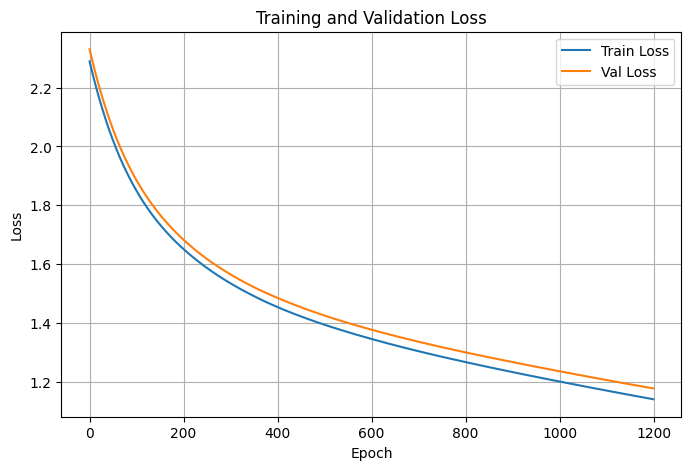

In [7]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
probs_test = NN.feedForward(X_test)
y_pred = np.argmax(probs_test, axis=1)
y_true = Y_test

accuracy = np.mean(y_pred == y_true)
print(f"\nTest Accuracy: {accuracy:.4f}\n")

precisions = []
recalls = []
f1s = []

for c in range(num_classes):
    TP = np.sum((y_pred == c) & (y_true == c))
    FP = np.sum((y_pred == c) & (y_true != c))
    FN = np.sum((y_pred != c) & (y_true == c))

    prec = TP / (TP + FP + 1e-8)
    rec  = TP / (TP + FN + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)

    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Class {c}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

counts = np.array([np.sum(y_true == c) for c in range(num_classes)])
weights = counts / counts.sum()
print("\nWeighted Precision:", np.sum(np.array(precisions) * weights))
print("Weighted Recall:   ", np.sum(np.array(recalls) * weights))
print("Weighted F1:       ", np.sum(np.array(f1s) * weights))



Test Accuracy: 0.5257

Class 0: Precision=0.5077, Recall=0.5294, F1=0.5183
Class 1: Precision=0.5198, Recall=0.6562, F1=0.5801
Class 2: Precision=0.6139, Recall=0.7006, F1=0.6544
Class 3: Precision=0.5583, Recall=0.5385, F1=0.5482
Class 4: Precision=0.3628, Recall=0.2253, F1=0.2780

Weighted Precision: 0.5110232401969196
Weighted Recall:    0.5257142856840005
Weighted F1:        0.5129135612458494


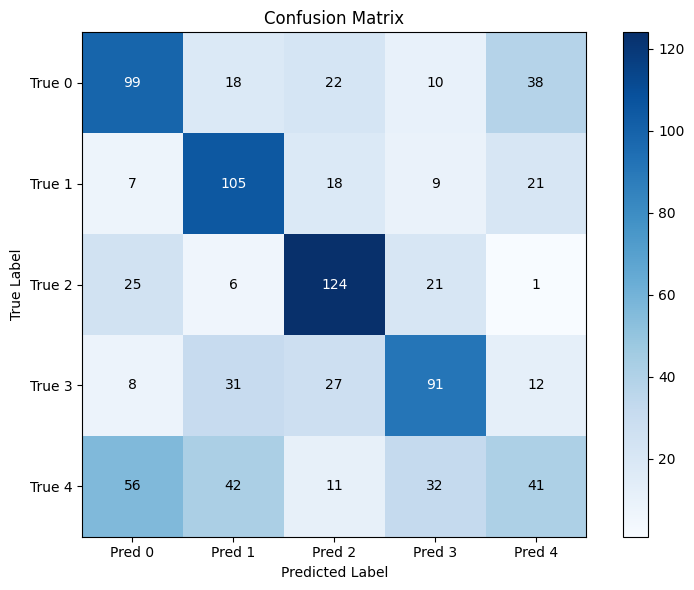

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Compute confusion matrix manually
num_classes = 5
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

#
final_pred = NN.predict(X_test)
for true, pred in zip(Y_test, final_pred):
    conf_matrix[true, pred] += 1

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [f"Pred {i}" for i in range(num_classes)])
plt.yticks(tick_marks, [f"True {i}" for i in range(num_classes)])

# Annotate cells
thresh = conf_matrix.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [10]:
import numpy as np

# Final predictions on test set
final_pred = NN.predict(X_test)

# ----- Per-class metrics -----
for c in range(num_classes):
    TP = conf_matrix[c, c]
    FP = np.sum(conf_matrix[:, c]) - TP
    FN = np.sum(conf_matrix[c, :]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    print(f"Class {c}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# ----- Overall Accuracy -----
accuracy = np.sum(final_pred == Y_test) / len(Y_test)
print(f"\nTotal Accuracy: {accuracy:.4f}")

Class 0: Precision=0.5077, Recall=0.5294, F1=0.5183
Class 1: Precision=0.5198, Recall=0.6562, F1=0.5801
Class 2: Precision=0.6139, Recall=0.7006, F1=0.6544
Class 3: Precision=0.5583, Recall=0.5385, F1=0.5482
Class 4: Precision=0.3628, Recall=0.2253, F1=0.2780

Total Accuracy: 0.5257
